<a href="https://colab.research.google.com/github/MHHamdan/Advanced-Deep-Learning-with-Keras/blob/master/Copy_of_map_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download the code zip file and Install the necessary packages

In [4]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/map-coco/map-coco.zip
!unzip -qq map-coco.zip
%cd map-coco/data
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip -qq val2017.zip
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -qq annotations_trainval2017.zip
!wget https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4.weights
%cd ../
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
!apt install libopencv-dev python-opencv ffmpeg
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/g' Makefile
!make
%cd ../

--2022-06-23 16:52:05--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/map-coco/map-coco.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 3.5.79.118
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|3.5.79.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580374 (567K) [binary/octet-stream]
Saving to: ‘map-coco.zip.1’

map-coco.zip.1      100%[===================>] 566.77K  1.67MB/s    in 0.3s    

2022-06-23 16:52:06 (1.67 MB/s) - ‘map-coco.zip.1’ saved [580374/580374]

replace map-coco/data/dog.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace map-coco/data/label2idx.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace map-coco/data/yolo_90_class_map.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y, A
replace map-coco/eval_iou.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes All
repl

_Note_: We need to modify the path to the `coco.names`

- In the left folder directory of colab open `map-coco`
- Open the `darknet` folder
- Open the `cfg` folder
- Double click `coco.data` file
- modify the `names` path to `darknet/data/coco.names`

## Blog Post Code

### Import Packages

In [5]:
# import the necessary packages
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
from progressbar import progressbar
from darknet import darknet
from glob import glob
import sklearn.metrics
import numpy as np
import pickle
import json
import cv2
import os

### Configuration and Arguments

In [6]:
class Config:
	# set the path for YOLOv4 config, YOLOv4 weight, and COCO data file
	YOLO_CONFIG = "darknet/cfg/yolov4.cfg"
	YOLO_WEIGHTS = "data/yolov4.weights"
	COCO_DATA = "darknet/cfg/coco.data"

	# YOLOv4 network input width and height
	YOLO_NETWORK_WIDTH = 608
	YOLO_NETWORK_HEIGHT = 608

	# path to label to index and YOLOv4 class map file
	LABEL2IDX = "data/label2idx.pkl"
	YOLO_90CLASS_MAP = "data/yolo_90_class_map.pkl"

	# path to validation images
	IMAGES_PATH = glob("data/val2017/*")

	# path to COCO ground truth annotations and validation predictions
	COCO_GT_ANNOTATION = "data/annotations/instances_val2017.json"
	COCO_VAL_PRED = "data/COCO_Val_Predictions.json"

	# set threshold, ground truth bounding box coordinates, and predicted
	# bounding box coordinates
	CONF_THRESHOLD = 0.25
	IOU_GT = [90, 80, 250, 450]
	IOU_PRED = [100, 100, 220, 400]

	# path to IoU and PR result
	IOU_RESULT = "results/dog_iou.png"
	PR_RESULT = "results/pr_curve.png"

	# ground truth prediction and predicted PR
	GROUND_TRUTH_PR = ["dog", "cat", "cat", "dog", "cat", "cat", "dog",
		"dog", "cat", "dog", "dog", "dog", "dog", "cat", "cat", "dog"]
	PREDICTION_PR = [0.7, 0.3, 0.5, 0.6, 0.3, 0.35, 0.55, 0.2, 0.4, 0.3,
		0.7, 0.5, 0.8, 0.2, 0.9, 0.4]

config = Config()

In [7]:
args = {
    "image": "data/dog.jpg"
}

### Intersection over Union

In [8]:
def plt_imshow(title, image, path):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.axis("off")
	plt.imsave(path, image)
	plt.show()

In [9]:
def intersection_over_union(gt, pred):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(gt[0], pred[0])
	yA = max(gt[1], pred[1])
	xB = min(gt[2], pred[2])
	yB = min(gt[3], pred[3])

	# if there is no overlap between predicted and ground-truth box
	if xB < xA or yB < yA:
		return 0.0

	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
	boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)

	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)

	# return the intersection over union value
	return iou

In [10]:
def compute_iou(imagePath):
	# load the image
	image = cv2.imread(imagePath)

	# define the top-left and bottom-right coordinates of ground-truth
	# and prediction
	groundTruth = [90, 80, 250, 450]
	prediction = [100, 100, 220, 400]

	# draw the ground-truth bounding box along with the predicted
	# bounding box
	cv2.rectangle(image, tuple(groundTruth[:2]),
		tuple(groundTruth[2:]), (0, 255, 0), 2)
	cv2.rectangle(image, tuple(prediction[:2]),
		tuple(prediction[2:]), (0, 0, 255), 2)

	# compute the intersection over union and display it
	iou = intersection_over_union(groundTruth, prediction)
	cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 34),
		cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 255, 0), 3)

	# show the output image
	plt_imshow("Image", image, config.IOU_RESULT)

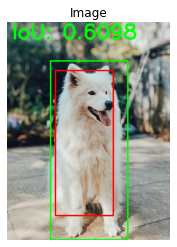

In [11]:
compute_iou(args["image"])

### Mean Average Pricision

In [12]:
def image_detection(imagePath, network, classnames, thresh):
	# image_detection takes the image as an input and returns
	# the detections to the calling function
	width = darknet.network_width(network)
	height = darknet.network_height(network)

	# create an empty darknetImage of shape [608, 608, 3]
	darknetImage = darknet.make_image(width, height, 3)

	# read the image from imagePath, convert from BGR->RGB
	# resize the image as per YOLOv4 network input size
	image = cv2.imread(imagePath)
	imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	imageResized = cv2.resize(imageRGB, (width, height),
		interpolation=cv2.INTER_LINEAR)

	darknet.copy_image_from_bytes(darknetImage, imageResized.tobytes())

	# detections include the class labels, bounding box coordinates, and
	# confidence score for all the proposed ROIs in the image
	detections = darknet.detect_image(network, classnames, darknetImage,
		thresh=thresh)
	darknet.free_image(darknetImage)

	# return the detections and image shape to the calling function
	return (detections, image.shape)

def bbox2points(bbox, imageShape):
	# grab the bounding box values
	(x, y, w, h) = bbox

	# compute scale ratio dividing by 608
	hRatio = imageShape[0] / config.YOLO_NETWORK_HEIGHT
	wRatio = imageShape[1] / config.YOLO_NETWORK_WIDTH
	xMin = int(round(x - (w / 2)))
	yMin = int(round(y - (h / 2)))

	# scale them as per the original image size
	return (xMin * wRatio, yMin * hRatio, w * wRatio, h * hRatio)

def load_yolo_cls_idx(path):
	# load pickle files: COCO `class_id` to the
	# class_name list and the COCO 0-90 class ids list
	with open(path, "rb") as f:
		out = pickle.load(f)
		return out

def run_inference(imagePaths, network, classnames,
	label2idx, yolocls90, thresh, predfile):
	results = []

	# loop over all the images
	for path in progressbar(imagePaths):
		# pass the imagePath, network, class names and confidence
		# threshold to image_detection method that returns detections
		# and original image shape
		detections, imgShape = image_detection(
			path, network, classnames, thresh=thresh
		)

		# extract imageID
		imageId = int(os.path.splitext(os.path.basename(path))[0])

		# loop over all the proposed ROIs
		for cls, conf, box in detections:
			(x, y, w, h) = bbox2points(box, imgShape)
			label = [key for key, value in label2idx.items()
					if value == cls][0]
			label = yolocls90[label]

			# append result for each ROI as per COCO prediction
			# in a dictionary format
			results.append({"image_id": imageId,
				"category_id": label, "bbox": [x, y, w, h],
				"score": float(conf)})

	# save the results on disk in a JSON format
	with open(predfile, "w") as f:
		json.dump(results, f, indent=4)

In [13]:
def compute_map():
	# use the COCO class to load and read the ground-truth annotations
	cocoAnnotation = COCO(annotation_file=config.COCO_GT_ANNOTATION)
	
	# call the darknet.load_network method, which loads the YOLOv4
	# network based on the configuration, weights, and data file
	(network, classNames, _) = darknet.load_network(
			config.YOLO_CONFIG,
			config.COCO_DATA,
			config.YOLO_WEIGHTS,
		)

	label2Idx = load_yolo_cls_idx(config.LABEL2IDX)
	yoloCls90 = load_yolo_cls_idx(config.YOLO_90CLASS_MAP)

	# call the run_inference function to generate prediction JSON file
	run_inference(config.IMAGES_PATH, network, classNames, label2Idx,
		yoloCls90, config.CONF_THRESHOLD, config.COCO_VAL_PRED)

	# load detection JSON file from the disk
	cocovalPrediction = cocoAnnotation.loadRes(config.COCO_VAL_PRED)

	# initialize the COCOeval object by passing the coco object with
	# ground truth annotations, coco object with detection results
	cocoEval = COCOeval(cocoAnnotation, cocovalPrediction, "bbox")
	
	# run evaluation for each image, accumulates per image results
	# display the summary metrics of the evaluation
	cocoEval.evaluate()
	cocoEval.accumulate()
	cocoEval.summarize()

In [ ]:
compute_map()

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


### Precision-Recall Curve

In [14]:
def compute_precision_recall(yTrue, predScores, thresholds):
	precisions = []
	recalls = []

	# loop over each threshold from 0.2 to 0.65
	for threshold in thresholds:
		# yPred is dog if prediction score greater than threshold
		# else cat if prediction score less than threshold
		yPred = [
			"dog" if score >= threshold else "cat"
			for score in predScores
		]
		
		# compute precision and recall for each threshold
		precision = sklearn.metrics.precision_score(y_true=yTrue,
			y_pred=yPred, pos_label="dog")
		recall = sklearn.metrics.recall_score(y_true=yTrue,
			y_pred=yPred, pos_label="dog")
		
		# append precision and recall for each threshold to
		# precisions and recalls list
		precisions.append(np.round(precision, 3))
		recalls.append(np.round(recall, 3))

	# return them to calling function
	return (precisions, recalls)

def pr_compute():
	# define thresholds from 0.2 to 0.65 with step size of 0.05
	thresholds = np.arange(start=0.2, stop=0.7, step=0.05)

	# call the compute_precision_recall function
	precisions, recalls = compute_precision_recall(
		yTrue=config.GROUND_TRUTH_PR, predScores=config.PREDICTION_PR,
		thresholds=thresholds,
	)
	
	# return the precisions and recalls
	return (precisions, recalls)

def plot_pr_curve(precisions, recalls, path):
	# plots the precision recall values for each threshold
	# and save the graph to disk
	plt.plot(recalls, precisions, linewidth=4, color="red")
	plt.xlabel("Recall", fontsize=12, fontweight='bold')
	plt.ylabel("Precision", fontsize=12, fontweight='bold')
	plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
	plt.savefig(path)
	plt.show()

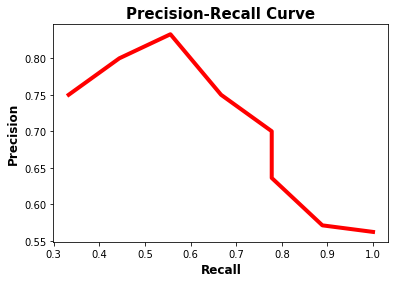

In [15]:
(precisions, recalls) = pr_compute()
plot_pr_curve(precisions, recalls, config.PR_RESULT)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Mean Average Precision (mAP) Using the Coco Evaluator*](https://pyimg.co/nwoka) published on 2022-05-02.